# The Inverted Pendulum (or the Cart-Pole System)

In this notebook, we will go through implementing the inverted pendulum system for which we'll train a neural network to learn to control the pendulum state.

A part of this exercise will also show you how to make animations in matplotlib!

In [1]:
import torch
import math
import copy

from IPython.display import HTML

import neuralode

In [2]:
# For convenience, we define the default tensor device and dtype here
torch.set_default_device('cuda')
# In neural networks, we prefer 32-bit/16-bit floats, but for precise integration, 64-bit is preferred. We will revisit this later when we need to mix integration with neural network training
torch.set_default_dtype(torch.float64)

## The Dynamics

The cart-pole system is a dynamical system comprising of a cart attached to a linear track with one-degree of freedom (the x-axis), and a rigid pole attach to the cart with one-degree of freedom (the rotational axis). While the equations can be complicated due to the interaction between the cart and the pole, the system itself is easy to imagine. Unlike the previous systems, we will not derive the equations of the system in this notebook as they require an understanding of force-balance equations, and instead quote them below[\[1\]](##references):

$$
\theta^{(2)}=
\frac{g\sin\theta + \cos\theta\left\{\frac{-F_p + d_N\cos\theta}{m_T} + g d_N\right\}-\frac{\mu_p\theta^{(1)}}{m_p l}}{l\left\{\frac{4}{3}-\frac{m_p\cos\theta}{m_T}\left[\cos\theta - d_N\right]\right\}}
$$
and
$$ x^{(2)} =
\frac{F_p - m_p l \theta^{(2)}\cos\theta - N_c d_N}{m_T}
$$
where 

$$
m_T = m_c + m_p
$$

$$
N_c=m_T g-m_p l \left(\theta^{(2)}\sin\theta +\left[\theta^{(1)}\right]^2\cos\theta\right)
$$

$$
d_N = \mu_c\mathrm{sgn}\left(N_c x^{(1)}\right)
$$

$$
F_p = F + m_p l \left[\theta^{(1)}\right]^2\sin\theta
$$
If we neglect friction (i.e. $\mu_p = \mu_c = 0$) then this simplifies to:

$$
\theta^{(2)}=
\frac{g\sin\theta + \cos\theta\frac{-F_p}{m_T}}{l\left\{\frac{4}{3}-\frac{m_p\cos^2\theta}{m_T}\right\}}
$$
and
$$
x^{(2)} = \frac{F_p - m_p l \theta^{(2)}\cos\theta}{m_T}
$$

Using the same transformation as before, we can write this as a first-order Ordinary Differential Equation by introducing $\omega=\theta^{(1)}$ and $v = x^{(1)}$ as variables and denoting the state $\vec{x}=\left[\theta, \omega, x, v\right]$, we get the dynamical equations
$$
\vec{x}^{(1)}=
\begin{bmatrix}
\omega \\
\frac{g\sin\theta + \cos\theta\left\{\frac{-F_p + d_N\cos\theta}{m_T} + g d_N\right\}-\frac{\mu_p\theta^{(1)}}{m_p l}}{l\left\{\frac{4}{3}-\frac{m_p\cos\theta}{m_T}\left[\cos\theta - d_N\right]\right\}} \\
v \\
\frac{F_p - m_p l \theta^{(2)}\cos\theta - N_c d_N}{m_T}
\end{bmatrix}
$$.

You'll note that the right-hand side of the equation depends on $\theta^{(2)}$ through $N_c$ which is also on the left-hand side of our equation. One way to solve this would be to use a non-linear root-finding algorithm to find the exact value of $\theta^{(2)}$ that satisfies this equation, but this would be computationally expensive. If you look closely, $N_c$ is the normal force applied by the track on the cart and for $\theta^{(2)}$ we only use its sign to determine the acceleration of the pole. In most cases, because the cart is attached to the track and weighed down, $N_c$ will be positive so we can assume that it is positive and compute $\theta^{(2)}$ accordingly. Once we've computed $\theta^{(2)}$, we can check that $N_c$ is still positive. If it isn't, we can recompute $\theta^{(2)}$. Because in most cases it will be positive, this incurs minimal computational cost in comparison to using a root-finding scheme.

In [3]:
### The System Parameters
mass_cart   = torch.tensor(1.0)  # kg
mass_pole   = torch.tensor(0.1)  # kg
length_pole = torch.tensor(1.0)  # m
gravity     = torch.tensor(9.81) # m/s^2
friction_cart = torch.tensor(0.0)
friction_pole = torch.tensor(0.0)

In [4]:
initial_state = torch.tensor([0.0,-1.0,0.0,0.1])

initial_time = torch.tensor(0.0)
final_time   = torch.tensor(5.0)

initial_timestep = torch.tensor(5e-4)

current_integrator = neuralode.integrators.AdaptiveRKV87Integrator

atol = rtol = torch.tensor(torch.finfo(initial_state.dtype).eps**0.5)

In [5]:
final_state, _, pendulum_states, pendulum_times, estimated_errors = current_integrator.apply(neuralode.dynamics.inverted_pendulum, initial_state, initial_time, final_time, initial_timestep, {'atol': atol, 'rtol': rtol}, torch.tensor(0.0), mass_cart, mass_pole, length_pole, gravity, friction_cart, friction_pole)

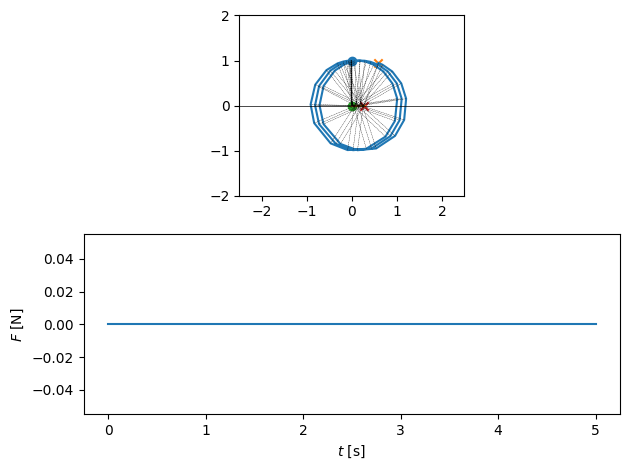

In [7]:
pendulum_x = torch.sin(pendulum_states[...,0]) * length_pole + pendulum_states[...,2]
pendulum_y = torch.cos(pendulum_states[...,0]) * length_pole

cart_x, cart_y = pendulum_states[...,2], torch.zeros_like(pendulum_states[...,2])

neuralode.plot.inverted_pendulum.plot_pendulum(pendulum_x, pendulum_y, cart_x, cart_y, pendulum_times, torch.zeros_like(pendulum_times))
HTML(neuralode.plot.inverted_pendulum.animate_pendulum(pendulum_x, pendulum_y, cart_x, cart_y, pendulum_times, frame_time=1000/24))

In [8]:
cart_pole_net = neuralode.models.inverted_pendulum.CartPoleNet()
cart_pole_net.apply(neuralode.models.util.init_weights)

def nn_controlled_pendulum(state, time, mc, mp, length, g, mu_c, mu_p, *args):
    force = cart_pole_net(state, time)[...,0]
    if torch.any(~torch.isfinite(force)):
        raise ValueError(f"Encountered non-finite force for input: {state[~torch.isfinite(force)]}")
    return neuralode.dynamics.inverted_pendulum(state, time, force, mc, mp, length, g, mu_c, mu_p)

In [9]:
# As the goal is balancing the pole on top of the cart, we generate initial states where the pole
# is near vertical and moving with some random rotational velocity. This way, the neural network observes
# multiple states near the vertical state where it needs to learn to counter-balance it.
num_examples = 16384
state_min = torch.tensor([-torch.pi, -torch.pi/(final_time - initial_time), -1.0, -1.0])
state_max = torch.tensor([ torch.pi,  torch.pi/(final_time - initial_time),  1.0,  1.0])
state_dataset = torch.rand(num_examples, *state_max.shape) * (state_max - state_min)[None] + state_min[None]

training_integrator_kwargs = {
    'atol': atol,
    'rtol': rtol
}

# As our network needs to minimize the angle and angular velocity across all timesteps,
# we can integrate our loss function alongside the system and then minimize its value at the end.
# Thus, implicitly reducing the total deviation for both angle and angular velocity.
def loss_func(x0):
    return x0[...,:4].square().sum(dim=-1, keepdim=True)

# We append one more state variable that will track our loss.
# Initially it is set to zero as our initial state is
# outside the control of our neural network
state_dataset = torch.cat([
    state_dataset,
    torch.zeros_like(state_dataset[...,:1]),
], dim=-1)


def loss_augmented_rhs(x0, t, *args):
    return torch.cat([
        nn_controlled_pendulum(x0[...,:4], t, *args),
        loss_func(x0[...,:4])
    ], dim=-1)


def batched_integrator(x0, integration_duration):
    return current_integrator.apply(loss_augmented_rhs, x0, initial_time, initial_time+integration_duration, initial_timestep, training_integrator_kwargs, mass_cart, mass_pole, length_pole, gravity, friction_cart, friction_pole, *cart_pole_net.parameters())

## Training Configuration

In [10]:
batch_size = 2048
number_of_epochs = 16
total_steps = math.ceil(state_dataset.shape[0] / batch_size) * number_of_epochs

optimiser = torch.optim.Adam(cart_pole_net.parameters(), lr=1e-4, amsgrad=True)
one_cycle_lr = torch.optim.lr_scheduler.OneCycleLR(optimiser, max_lr=4e-3, total_steps=total_steps, three_phase=True)

def pendulum_closure(minibatch, integration_duration):
    optimiser.zero_grad()
    
    states = minibatch['states']
    
    final_state, *_ = batched_integrator(states, integration_duration)

    # The error is simply the integrated error over the whole trajectory
    error = final_state[...,:4].square().sum(dim=-1).mean() + 1e-1*final_state[...,-1].mean()
    
    if error.requires_grad:
        error.backward()
    return error

In [11]:
best_error = torch.inf
best_params = copy.deepcopy(cart_pole_net.state_dict())

cart_pole_net.train()

# At the beginning, the network will have no idea how to balance the pole
# so instead of giving the full problem, we train with a small time-horizon.
# Over the training, we increase this horizon so that the network learns 
# in tandem with the growing complexity of balancing the pole for longer.
total_integration_time = torch.tensor(0.1)
integration_time_growth_rate = ((1.0 - initial_time) - total_integration_time)/number_of_epochs

for step in range(number_of_epochs):
    epoch_error = 0.0
    shuffled_indices = torch.randperm(state_dataset.shape[0])
    for batch_idx in range(0, state_dataset.shape[0], batch_size):
        batch_dict = {
            'states': state_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
        }
    
        step_error = optimiser.step(lambda: pendulum_closure(batch_dict, total_integration_time))
        one_cycle_lr.step()
        if any(torch.any(~torch.isfinite(i)) for i in cart_pole_net.parameters()) or any(torch.any(~torch.isfinite(i.grad)) for i in cart_pole_net.parameters() if i.requires_grad):
            raise ValueError("Encountered non-finite parameters/parameters gradients")
        epoch_error = epoch_error + step_error.item()*batch_dict['states'].shape[0]
        print(f"[{step+1}/{number_of_epochs} - {optimiser.param_groups[0]['lr']:.4e}]/[{batch_idx}/{state_dataset.shape[0]}] Batch Error: {step_error:.6f}", end='\r')
    epoch_error = epoch_error/state_dataset.shape[0]
    if epoch_error < best_error:
        best_error = epoch_error
        best_params = copy.deepcopy(cart_pole_net.state_dict())
    print(" "*128, end="\r")
    print(f"[{step+1}/{number_of_epochs} - {optimiser.param_groups[0]['lr']:.4e} - horizon: {total_integration_time:.2f}] Epoch Error: {epoch_error:.6f}")
    with torch.no_grad():
        total_integration_time += integration_time_growth_rate
    torch.cuda.empty_cache()

[1/16 - 5.7745e-04 - horizon: 0.10] Epoch Error: 847.021244                                                                     
[2/16 - 1.6483e-03 - horizon: 0.16] Epoch Error: 271.405752                                                                     
[3/16 - 2.9068e-03 - horizon: 0.21] Epoch Error: 179.625616                                                                     
[4/16 - 3.8058e-03 - horizon: 0.27] Epoch Error: 39.040017                                                                      
[5/16 - 3.9544e-03 - horizon: 0.33] Epoch Error: 12.603931                                                                      
[6/16 - 3.2879e-03 - horizon: 0.38] Epoch Error: 14.153745                                                                      
[7/16 - 2.0961e-03 - horizon: 0.44] Epoch Error: 16.635966                                                                      
[8/16 - 8.9737e-04 - horizon: 0.49] Epoch Error: 19.291207                                       

In [12]:
cart_pole_net.eval()

with torch.no_grad():
    final_state, _, controlled_pendulum_states, controlled_pendulum_times, errors_achieved = current_integrator.apply(nn_controlled_pendulum, initial_state, initial_time, final_time, initial_timestep, {'atol': atol, 'rtol': rtol}, mass_cart, mass_pole, length_pole, gravity, friction_cart, friction_pole)

In [13]:
controlled_pendulum_times.diff().mean(), controlled_pendulum_times.diff().max(), controlled_pendulum_times.diff().min(), errors_achieved

(tensor(0.0054, device='cuda:0'),
 tensor(0.0091, device='cuda:0'),
 tensor(0.0005, device='cuda:0'),
 tensor([0.0000e+00, 2.2707e-11, 3.9763e-11, 4.4233e-09, 1.8584e-09, 1.5497e-09,
         1.2962e-09, 6.8705e-10, 3.3902e-09, 1.2943e-09, 2.5769e-09, 1.2075e-09,
         1.5529e-09, 1.0370e-09, 9.6633e-10, 7.4780e-10, 1.0170e-09, 3.3682e-09,
         4.6283e-09, 3.8880e-09, 3.5401e-09, 3.7294e-09, 3.8379e-09, 3.7832e-09,
         3.7451e-09, 3.7605e-09, 3.7742e-09, 3.7699e-09, 3.7616e-09, 3.7604e-09,
         3.7595e-09, 3.7558e-09, 3.7489e-09, 3.7380e-09, 3.7267e-09, 3.7103e-09,
         3.6852e-09, 3.6503e-09, 3.5984e-09, 3.5178e-09, 3.3792e-09, 3.1022e-09,
         2.3573e-09, 1.8141e-09, 1.4337e-09, 6.3896e-09, 6.8241e-09, 3.8511e-09,
         3.5101e-09, 4.4932e-09, 4.6812e-09, 4.3384e-09, 4.2977e-09, 4.4223e-09,
         4.4500e-09, 4.4375e-09, 4.4551e-09, 4.4811e-09, 4.5000e-09, 4.5183e-09,
         4.5391e-09, 4.5609e-09, 4.5823e-09, 4.6048e-09, 4.6275e-09, 4.6512e-09,
       

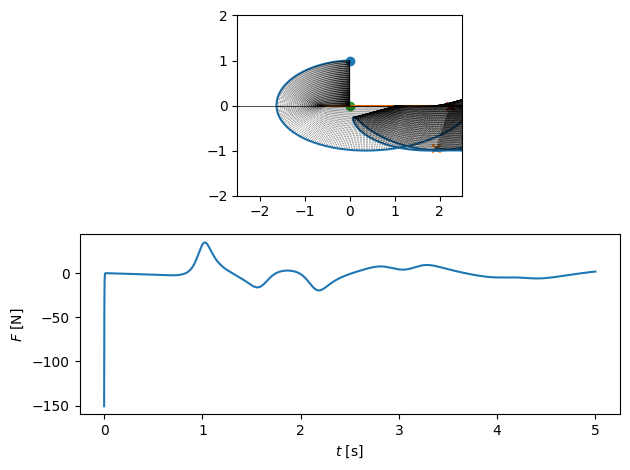

In [14]:
cart_x = controlled_pendulum_states[...,2]
cart_y = torch.zeros_like(cart_x)

pendulum_x = torch.sin(controlled_pendulum_states[...,0]) * length_pole + cart_x
pendulum_y = torch.cos(controlled_pendulum_states[...,0]) * length_pole

with torch.no_grad():
    controller_force = cart_pole_net(controlled_pendulum_states, controlled_pendulum_times)[...,0]
neuralode.plot.inverted_pendulum.plot_pendulum(pendulum_x, pendulum_y, cart_x, cart_y, controlled_pendulum_times, controller_force)
HTML(neuralode.plot.inverted_pendulum.animate_pendulum(pendulum_x, pendulum_y, cart_x, cart_y, controlled_pendulum_times, forces=controller_force, frame_time=1000/24))

## References
\[1\]: https://coneural.org/florian/papers/05_cart_pole.pdf